<a href="https://colab.research.google.com/github/najnin26/DL_Algo_Implement/blob/main/Data%20Augmentation/Image_Augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
%%capture
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from keras import layers
import keras

In [27]:
%%capture
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [28]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

2


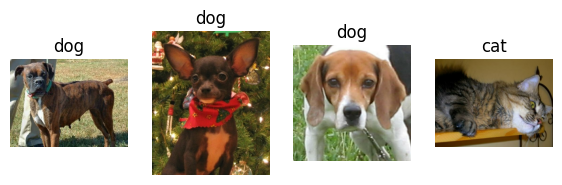

In [29]:
get_label_name = metadata.features['label'].int2str
train_iter = iter(train_ds)
fig = plt.figure(figsize=(7, 8))
for x in range(4):
  image, label = next(train_iter)
  fig.add_subplot(1, 4, x+1)
  plt.imshow(image)
  plt.axis('off')
  plt.title(get_label_name(label));

# Data Augmentation with Keras Sequential
- Resize and rescale
- Random rotate and flip
- Directly adding to the model layer
- Applying the augmentation function using .map
- Data pre-processing
- Model building
- Training and evaluation

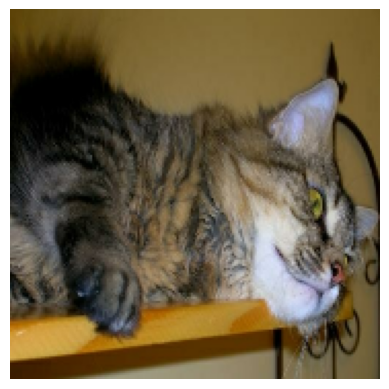

In [30]:
# Resize and rescale
IMG_SIZE = 180

resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

result = resize_and_rescale(image)
plt.axis('off')
plt.imshow(result);

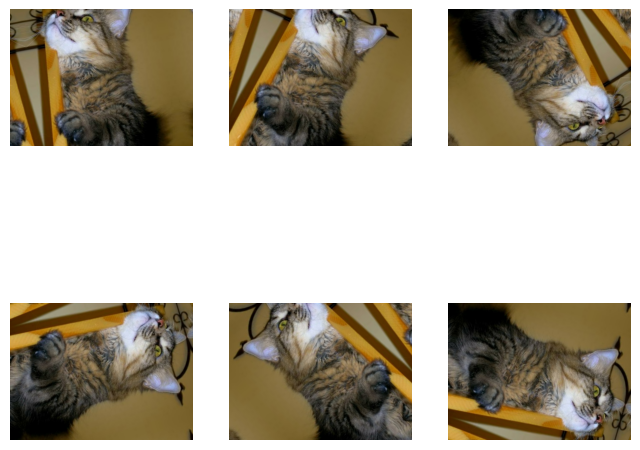

In [31]:
# Random rotate and flip
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.4),
])


plt.figure(figsize=(8, 7))
for i in range(6):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(augmented_image.numpy()/255)
  plt.axis("off")

In [32]:
# Directly adding to the model layer
model = keras.Sequential([
  # Add the preprocessing layers you created earlier.
  resize_and_rescale,
  data_augmentation,
  # Add the model layers
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1,activation='sigmoid')
])

In [33]:
# Applying the augmentation function using .map
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [34]:
# Data pre-processing

batch_size = 32
def prepare(ds, shuffle=False, augment=False):
    AUTOTUNE = tf.data.AUTOTUNE
    # Apply data augmentation before resizing/rescaling if augment=True
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    # Resize and rescale all datasets
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), num_parallel_calls=AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000)
    # Batch and prefetch datasets
    ds = ds.batch(batch_size)
    return ds.prefetch(buffer_size=AUTOTUNE)

# Prepare the datasets
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

In [35]:
# Model building
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), input_shape=(180,180,3), padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(1,activation='softmax')
])

In [36]:
# Training and evaluation
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
epochs=1
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

582/582 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.4905 - loss: 1.0099 - val_accuracy: 0.5185 - val_loss: 0.6932


In [37]:
loss, acc = model.evaluate(test_ds)

73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 289ms/step - accuracy: 0.4831 - loss: 0.6931


## Data Augmentation using tf.image
- Data Loading
- Flip left to right
- Grayscale
- Adjusting the saturation
- Adjusting the brightness
- Central Crop
- 90-degree rotation
- Applying random brightness
- Applying the augmentation function

In [38]:
%%capture
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

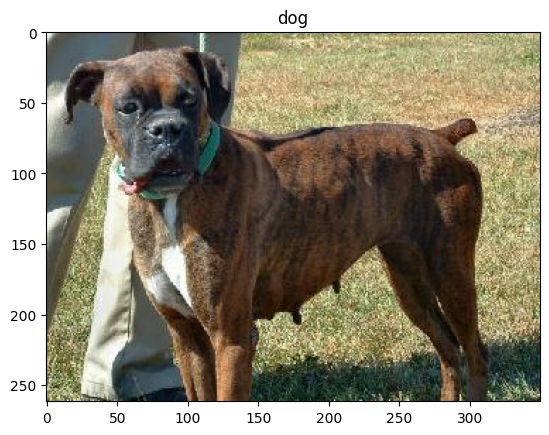

In [41]:
image, label = next(iter(train_ds))
plt.imshow(image)
plt.title(get_label_name(label));

In [42]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

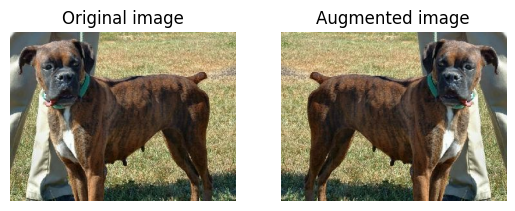

In [43]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

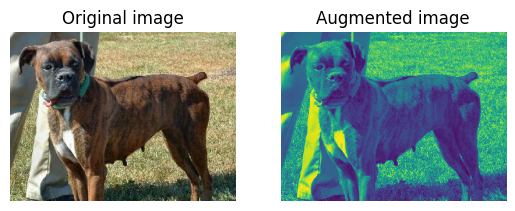

In [44]:
grayscaled = tf.image.rgb_to_grayscale(image)
visualize(image,  tf.squeeze(grayscaled))

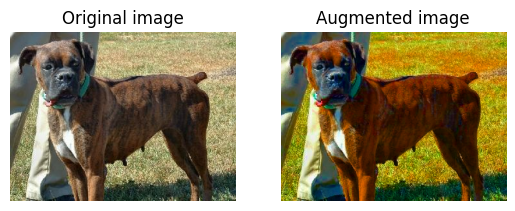

In [45]:
saturated = tf.image.adjust_saturation(image, 3)
visualize(image, saturated)

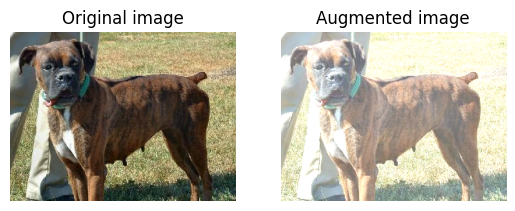

In [46]:
bright = tf.image.adjust_brightness(image, 0.4)
visualize(image, bright)

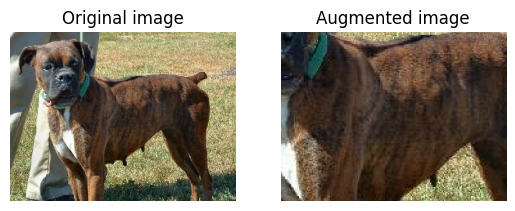

In [47]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

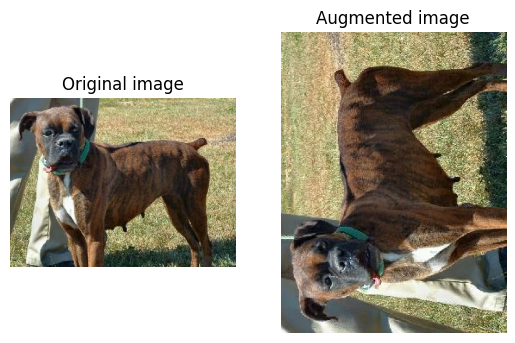

In [48]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

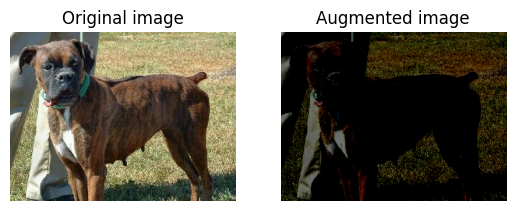

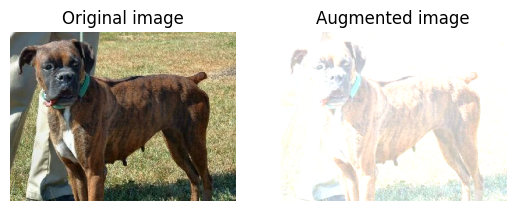

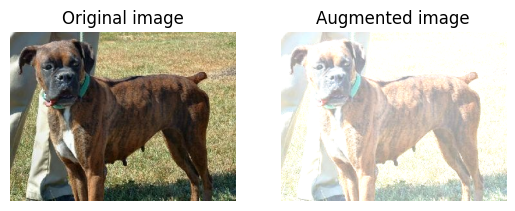

In [49]:
for i in range(3):
  seed = (i, 0)  # tuple of size (2,)
  stateless_random_brightness = tf.image.stateless_random_brightness(
      image, max_delta=0.95, seed=seed)
  visualize(image, stateless_random_brightness)

In [51]:
def augment(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = (image / 255.0)
  image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
  image = tf.image.random_brightness(image, max_delta=0.5)
  return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_ds = (
    train_ds
    .shuffle(1000)
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(batch_size)
    .prefetch(AUTOTUNE)
)

# Data Augmentation with ImageDataGenerator

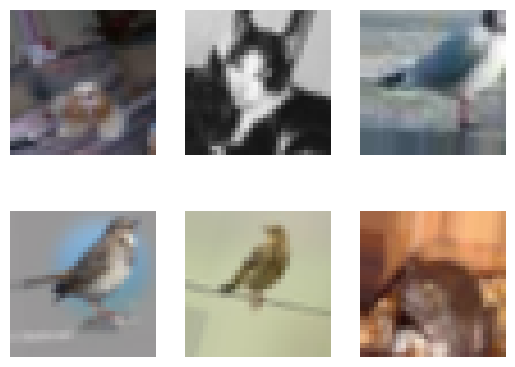

In [54]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
import matplotlib.pyplot as plt

# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

# Create ImageDataGenerator with data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

# Fit the generator on the training data
datagen.fit(x_train)

# Visualize some augmented images
for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=6):
    for i in range(0, 6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(X_batch[i] / 255)
        plt.axis('off')
    break  # Stop after the first batch